# 基于Mindspore 框架的CNN+CTC文本识别案例实现

## 1、概述

### 1.1 文本识别流程介绍

文本识别指从图像中识别出文本，将图像中的文字区域转化为字符信息，通常采用CNN网络从图像中提取丰富的特征信息，然后根据提取的特征信息进行识别。这里采用ResNet作为特征提取网络，采用CTC方法进行识别。由于每张样本的字符数量不同，字符样式不同，字体大小也不同，导致每列的输出并不一定能与每个字符一一对应，CTC提出一种不需要对齐的Loss计算方法，用于训练网络。

#### 整个模型的文本识别流程如下：

##### 1、通过CNN（ResNet）提取文本图片中的Feature map
##### 2、对每张图片中的feature map 划分为不同的特征序列（也可使用BiLSTM充分利用上下文信息获取更好的序列，这里为了减少计算复杂度和内存消耗，没有使用BiLSTM）
##### 3、对每个序列进行字符分类
##### 4、使用Connectionist temporal classification(CTC)损失函数计算loss(输入与标签长度不一致),CTC能够根据固定长度的特征序列预测非固定长度的标签。
#### 整体流程图如下
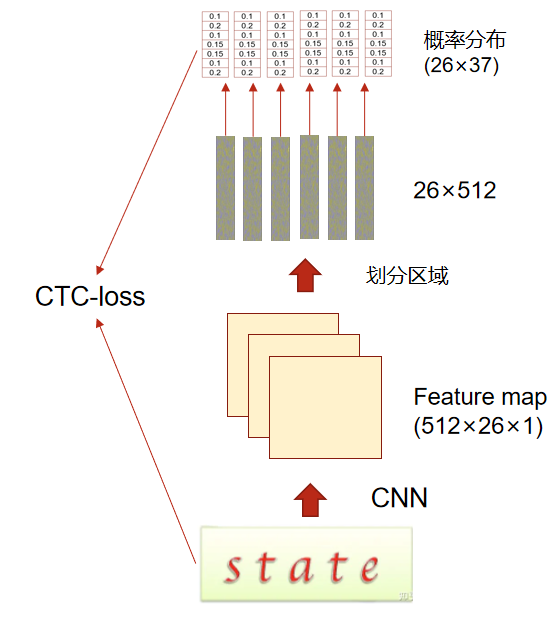


### 1.2 Connectionist temporal classfication(CTC)

对于固定长度的输出和可变长度的标签数据，CTC提供了一种计算loss的方法，用于训练网络参数。CTC的关键方法是预测每列的字符并通过删除重复的字符和空白将整个字符序列修改为非固定的字符流。
#### 根据模型得到的序列在每个位置上的概率分布获得定长的字符序列
模型输出的序列H = $h_1$, . . . , $h_T$，其中T为序列长度，这个序列长度是固定的,$\pi$为根据序列的概率分布得到的字符序列，其概率定义为
$$p(\pi|H)=\prod_{t=1}^{T}{y^t_{\pi_t}}$$

,其中$y^t_{\pi_t}$为在每个时间步t生成字符$\pi_t$的概率。
#### 定长的字符序列变为非固定长度序列
映射函数M，通过删除重复字符和空白，将$\pi$映射到Y。
例如，对于‘aaa-dd-d-c-d---d’,映射函数M将其映射为‘addcdd’,其中‘-’表示空白。
#### 条件概率定义
条件概率则定义为所有能够通过映射函数M映射到标签字符序列Y上的定长字符序列$\pi$的概率之和：
$$
p(Y|H)= \displaystyle \sum^{ }_{\pi:M(\pi)=Y}{P(\pi|H)}
$$
#### 目标函数
训练的目标是使得这个条件概率取得最大值，而且计算条件概率的过程只有加和乘操作，一定是可导的，故可以得到一个梯度来进行网络模型参数的更新
$$
p(Y|H)=- \displaystyle \sum^{ }_{X_i,Y_i\in TD}{logP(Y_i|X_i)}
$$
TD表示训练数据集
#### 测试
在进行测试的时候，在每个时间步，取具有最大概率的字符，来作为预测的标签序列
$$
Y^*\approx M(arg  max  P(\pi|H))
$$

### 1.3 ResNet网络特征提取器

残差神经网络(ResNet)是由微软研究院的何恺明、张祥雨、任少卿、孙剑等人提出的。ResNet 在2015 年的ILSVRC（ImageNet Large Scale Visual Recognition Challenge）中取得了冠军。残差神经网络的主要贡献是发现了“退化现象（Degradation）”，并针对退化现象发明了 “快捷连接（Shortcut connection）”，极大的消除了深度过大的神经网络训练困难问题。

残差网络结构是ResNet的主要亮点，ResNet使用残差网络结构后可有效地减轻退化问题，实现更深的网络结构设计，提高网络的训练精度

#### 构建残差网络结构

残差网络结构由两个分支构成：一个主分支，一个shortcuts。主分支通过堆叠一系列卷积操作得到，shortcuts从输入直接到输出，主分支得到的输出加上shortcuts得到的输出，通过Relu激活函数后即为残差网络最后的输出。

这里使用的残差网络结构，主分支有两层卷积网络结构：

- 第一层网络，kernel_size为3的卷积层 + BatchNorm + Relu
- 第二层网络，kernel_size为3的卷积层 + BatchNorm

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为残差网络结构的最终输出。

#### 构建ResNet网络结构

这里的ResNet由5层网络结构组成：

- 第一层，kernel_size为3的卷积层 + BatchNorm + kernel_size为3的卷积层 + BatchNorm + Relu
- 第二层，最大池化 + 残差网络 + kernel_size为3的卷积层 + BatchNorm
- 第三层，最大池化 + 残差网络 + kernel_size为3的卷积层 + BatchNorm
- 第四层，最大池化 + 残差网络 + kernel_size为3的卷积层 + BatchNorm
- 第五层， 残差网络 + kernel_size为2的卷积层 + BatchNorm + kernel_size为2的卷积层 + BatchNorm 

#### ResNet各层配置及输出
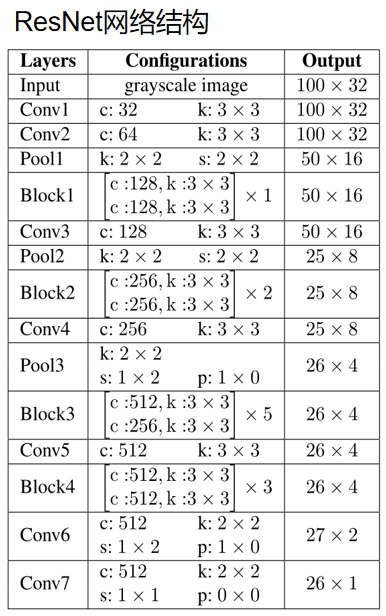


In [2]:
#安装必要依赖
!pip install -r requirements.txt

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
     |████████████████████████████████| 292 kB 38.7 MB/s eta 0:00:01


## 2 案例实现

### 2.1 数据准备
为了使得训练的结果更具有说明性，采用了多个数据集进行训练，在训练之前需要将多个数据集合并为一个数据集；同时数据集中每条数据的标签长度不一，为了达到更好的训练效果，希望每次训练的数据的标签长度都一致，在提取数据的时候需要按照一定的索引进行提取。
#### 2.1.1 数据集及目录结构
采用合成数据集进行训练，真实数据集用于测试

##### MJSynth（MJ）
MJSynth（MJ）是一个为STR设计的合成数据集，包含8.9M个单词框图像。单词框生成过程如下：1）字体渲染，2）边框和阴影渲染，3）背景着色，4）字体、边框和背景的合成，5）应用投影失真，6）与真实图像混合，7）添加噪声。

##### SynthText（ST）
SynthText（ST）是另一个合成产生的数据集，最初设计用于场景文本检测。尽管SynthText是为场景文本检测任务设计的，但它也可以通过裁剪单词框用于STR。通过裁剪单词框并过滤为非字母数字字符后，SynthText包含5.5 M个单词框图像。

##### IIIT5K Words（IIIT）
IIIT5K Words（IIIT）是从Google图像搜索中抓取的数据集，其中包含可能返回文本图像的查询词，例如“广告牌”、“招牌”，“门牌号”、“门牌号”和“电影海报”。IIIT包括2000张用于训练的图像和3000张用于评估的图像。

##### 目录结构

In [ ]:
#合并前
|--- CNNCTC/
    |--- cnnctc_data/
        |--- ST/
            data.mdb
            lock.mdb
        |--- MJ/
            data.mdb
            lock.mdb
        |--- IIIT/
            data.mdb
            lock.mdb

#合并后

|--- CNNCTC/
    |--- cnnctc_data/
        |--- ST/
            data.mdb
            lock.mdb
        |--- MJ/
            data.mdb
            lock.mdb
        |--- IIIT/
            data.mdb
            lock.mdb
        |--- ST_MJ/
            data.mdb
            lock.mdb
        st_mj_fixed_length_index_list.pkl

#### 2.1.2 数据集合并及索引生成

##### 数据集合并
依次打开数据集的lmdb文件，读取图片和标签，并写入同一个新的lmdb文件中
##### 分析新数据集中的标签的长度分布以及组合
在一个batch中所有数据的label总长度固定的情况下，得到batch中组成数据的label的长度的可能组合
1、首先得到每条数据中标签的长度，获取数据集中各种标签长度的分布情况，以及数据集中所有标签的总长度
2、根据数据计算每个batch中的标签的平均长度
3、根据batch中的平均长度以及各种标签长度的分布情况，获得可能的组合，使得每个batch的平均长度相同
##### 根据标签组合得到一个索引表
根据获取的可能组合，形成训练时采集数据的索引列表
注意：这里的num_of_iters应该根据实际训练数据集的大小进行适当调整
在采样过程中，是根据标签长度组合随机选择的，故num_of_iters应该设置稍微大一点，才能基本将数据集中所有数据都采集一遍

实现代码如下：

In [1]:
import lmdb
from tqdm import tqdm
import numpy as np
import random
import pickle
def combine_lmdbs(lmdb_paths, lmdb_save_path):
    max_len = int((26 + 1) // 2)
    character = '0123456789abcdefghijklmnopqrstuvwxyz'
    env_save = lmdb.open(lmdb_save_path,map_size=1099511627776)
    cnt = 0
    for lmdb_path in lmdb_paths:
        env = lmdb.open(lmdb_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with env.begin(write=False) as txn:
            nSamples = int(txn.get('num-samples'.encode()))
            nSamples = nSamples
            # Filtering
            for index in tqdm(range(nSamples)):
                index += 1  # lmdb starts with 1
                label_key = 'label-%09d'.encode() % index
                label = txn.get(label_key).decode('utf-8')
                if len(label) > max_len:
                    continue
                illegal_sample = False
                for char_item in label.lower():
                    if char_item not in character:
                        illegal_sample = True
                        break
                if illegal_sample:
                    continue
                img_key = 'image-%09d'.encode() % index
                imgbuf = txn.get(img_key)
                with env_save.begin(write=True) as txn_save:
                    cnt += 1
                    label_key_save = 'label-%09d'.encode() % cnt
                    label_save = label.encode()
                    image_key_save = 'image-%09d'.encode() % cnt
                    image_save = imgbuf
                    txn_save.put(label_key_save, label_save)
                    txn_save.put(image_key_save, image_save)
    nSamples = cnt
    with env_save.begin(write=True) as txn_save:
        txn_save.put('num-samples'.encode(), str(nSamples).encode())
        
#在一个batch中所有数据的label总长度固定的情况下，batch中组成数据的label的长度的可能组合
#首先得到每条数据中标签的长度，获取数据集中各种标签长度的分布情况，以及数据集中所有标签的总长度
#获取每个batch中的平均长度
#根据batch中的平均长度以及各种标签长度的分布情况，获得可能的组合，使得每个batch的平均长度相同
def analyze_lmdb_label_length(lmdb_path, batch_size=64, num_of_combinations=1000):
    label_length_dict = {}

    env = lmdb.open(lmdb_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
    with env.begin(write=False) as txn:
        nSamples = int(txn.get('num-samples'.encode()))
        nSamples = nSamples

        for index in tqdm(range(nSamples)):
            index += 1  # lmdb starts with 1
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')

            label_length = len(label)
            if label_length in label_length_dict:
                label_length_dict[label_length] += 1
            else:
                label_length_dict[label_length] = 1

    sorted_label_length = sorted(label_length_dict.items(), key=lambda x: x[1], reverse=True)

    label_length_sum = 0
    label_num = 0
    lengths = []
    p = []
    for l, num in sorted_label_length:
        label_length_sum += l * num
        label_num += num
        p.append(num)
        lengths.append(l)
    for i, _ in enumerate(p):
        p[i] /= label_num

    average_overall_length = int(label_length_sum / label_num * batch_size)

    def get_combinations_of_fix_length(fix_length, items, p, batch_size):
        ret = []
        cur_sum = 0
        ret = np.random.choice(items, batch_size - 1, True, p)
        cur_sum = sum(ret)
        ret = list(ret)
        if fix_length - cur_sum in items:
            ret.append(fix_length - cur_sum)
        else:
            return None
        return ret

    result = []
    while len(result) < num_of_combinations:
        ret = get_combinations_of_fix_length(average_overall_length, lengths, p, batch_size)
        if ret is not None:
            result.append(ret)
    return result

#根据获取的可能组合，形成训练时采集数据的索引列表
#注意：这里的num_of_iters应该根据实际训练数据集的大小进行适当调整
#在采样过程中，是根据标签长度组合随机选择的，故num_of_iters应该设置稍微大一点，才能基本将数据集中所有数据都采集一遍
def generate_fix_shape_index_list(lmdb_path, combinations, pkl_save_path, num_of_iters=650):
    length_index_dict = {}

    env = lmdb.open(lmdb_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
    with env.begin(write=False) as txn:
        nSamples = int(txn.get('num-samples'.encode()))
        nSamples = nSamples

        for index in tqdm(range(nSamples)):
            index += 1  # lmdb starts with 1
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')

            label_length = len(label)
            if label_length in length_index_dict:
                length_index_dict[label_length].append(index)
            else:
                length_index_dict[label_length] = [index]

    ret = []
    for _ in range(num_of_iters):
        comb = random.choice(combinations)
        for l in comb:
            ret.append(random.choice(length_index_dict[l]))

    with open(pkl_save_path, 'wb') as f:
        pickle.dump(ret, f, -1)

combine_lmdbs(['cnnctc_data/ST/', 'cnnctc_data/MJ/'], 'cnnctc_data/ST_MJ')
combination = analyze_lmdb_label_length("cnnctc_data/ST_MJ")
generate_fix_shape_index_list('cnnctc_data/ST_MJ', combination,'cnnctc_data/st_mj_fixed_length_index_list.pkl')


100%|██████████| 39550/39550 [00:00<00:00, 387371.15it/s]


#### 2.1.2 数据集创建
经过上面数据集合并后，数据是以图片和文本标签的形式放在lmdb文件中的，在模型训练中，我们需要将图片和标签以tensor向量进行表示
首先，从lmdb文件中读取图片和标签；然后对图片进行归一化处理，resize为相同的size，再把图像转为tensor，把文本标签转为编码形式。

通过定义了 ST_MJ_Generator_batch_fixed_length类（Data_loader类）来提取数据，在该类的__init__函数中，设置图片归一化处理函数，文本标签编码函数，分布式处理设置，batch_size大小。在该类的__getitem__函数中，通过传入索引值读取训练集中的样本和标签图像，并对图像进行对应的数据处理操作，就完成了__getitem__函数对样本和标签图像的读取。在函数中实例化ST_MJ_Generator_batch_fixed_length类获取st_dataset，也就是训练集或验证集对应路径下的样本和标签元组对，再通过mindspore.dataset中的GeneratorDataset将元组转换为Tensor，最后通过设定好的batch_size将样本和标签按照batch_size大小分组，由此完成数据集的创建，上述流程对应代码如下：

In [17]:
import six
import lmdb
import numpy as np
from PIL import Image
import pickle
import math
from mindspore.communication.management import init, get_rank, get_group_size

#从lmdb文件中读取图片和标签
def get_img_from_lmdb(env, index):
    with env.begin(write=False) as txn:
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)

        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')  # for color image

        except IOError:
            print(f'Corrupted image for {index}')
            # make dummy image and dummy label for corrupted image.
            img = Image.new('RGB', (config.IMG_W, config.IMG_H))
            label = '[dummy_label]'

    label = label.lower()

    return img, label

#对图片进行归一化
class NormalizePAD():

    def __init__(self, max_size, PAD_type='right'):
        self.max_size = max_size
        self.PAD_type = PAD_type

    def __call__(self, img):
        # toTensor
        img = np.array(img, dtype=np.float32)
        # normalize
        means = [121.58949, 123.93914, 123.418655]
        stds = [65.70353, 65.142426, 68.61079]
        img = np.subtract(img, means)
        img = np.true_divide(img, stds)

        img = img.transpose([2, 0, 1])
        img = img.astype(float)

        _, _, w = img.shape
        Pad_img = np.zeros(shape=self.max_size, dtype=np.float32)
        Pad_img[:, :, :w] = img  # right pad
        if self.max_size[2] != w:  # add border Pad
            Pad_img[:, :, w:] = np.tile(np.expand_dims(img[:, :, w - 1], 2), (1, 1, self.max_size[2] - w))

        return Pad_img
    
#图片resize后转为统一shape的tensor
class AlignCollate():

    def __init__(self, imgH=32, imgW=100):
        self.imgH = imgH
        self.imgW = imgW

    def __call__(self, images):

        resized_max_w = self.imgW
        input_channel = 3
        transform = NormalizePAD((input_channel, self.imgH, resized_max_w))

        resized_images = []
        for image in images:
            w, h = image.size
            ratio = w / float(h)
            if math.ceil(self.imgH * ratio) > self.imgW:
                resized_w = self.imgW
            else:
                resized_w = math.ceil(self.imgH * ratio)

            resized_image = image.resize((resized_w, self.imgH), Image.BICUBIC)
            resized_images.append(transform(resized_image))

        image_tensors = np.concatenate([np.expand_dims(t, 0) for t in resized_images], 0)

        return image_tensors

    
#文本标签到索引标签之间的转换
#将文本转换为数字编码
#CHARACTER: "0123456789abcdefghijklmnopqrstuvwxyz"
#则‘hate’----->[18,11,30,15]
class CTCLabelConverter():
    """ Convert between text-label and text-index """

    def __init__(self, character):
        # character (str): set of the possible characters.
        dict_character = list(character)

        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i

        self.character = dict_character + ['[blank]']  # dummy '[blank]' token for CTCLoss (index 0)
        self.dict['[blank]'] = len(dict_character)

    def encode(self, text):
        """convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]

        output:
            text: concatenated text index for CTCLoss.
                    [sum(text_lengths)] = [text_index_0 + text_index_1 + ... + text_index_(n - 1)]
            length: length of each text. [batch_size]
        """
        length = [len(s) for s in text]
        text = ''.join(text)
        text = [self.dict[char] for char in text]

        return np.array(text), np.array(length)

    def decode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]

            char_list = []
            for i in range(l):
                # if t[i] != self.dict['[blank]'] and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                if t[i] != self.dict['[blank]'] and (
                        not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)

            texts.append(text)
            index += l
        return texts

    def reverse_encode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]

            char_list = []
            for i in range(l):
                if t[i] != self.dict['[blank]']:  # removing repeated characters and blank.
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)

            texts.append(text)
            index += l
        return texts

#训练数据集封装
class ST_MJ_Generator_batch_fixed_length:
    def __init__(self):
        self.align_collector = AlignCollate()
        self.converter = CTCLabelConverter(config.CHARACTER)
        self.env = lmdb.open(config.TRAIN_DATASET_PATH, max_readers=32, readonly=True, lock=False, readahead=False,
                             meminit=False)
        if not self.env:
            print('cannot create lmdb from %s' % (config.TRAIN_DATASET_PATH))
            raise ValueError(config.TRAIN_DATASET_PATH)

        with open(config.TRAIN_DATASET_INDEX_PATH, 'rb') as f:
            self.st_mj_filtered_index_list = pickle.load(f)

        print(f'num of samples in ST_MJ dataset: {len(self.st_mj_filtered_index_list)}')
        
        
        if config.run_distribute:
            self.rank_id = get_rank()
            self.rank_size = get_group_size()
            self.dataset_size = len(self.st_mj_filtered_index_list) // config.TRAIN_BATCH_SIZE // self.rank_size
        else:
            self.dataset_size = len(self.st_mj_filtered_index_list) // config.TRAIN_BATCH_SIZE
        self.batch_size = config.TRAIN_BATCH_SIZE

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, item):
        img_ret = []
        text_ret = []
        
        if config.run_distribute:
            rank_item = (item * self.rank_size) + self.rank_id
        else:
            rank_item = item
        for i in range(rank_item * self.batch_size, (rank_item + 1) * self.batch_size):
            index = self.st_mj_filtered_index_list[i]
            img, label = get_img_from_lmdb(self.env, index)

            img_ret.append(img)
            text_ret.append(label)

        img_ret = self.align_collector(img_ret)
        text_ret, length = self.converter.encode(text_ret)

        label_indices = []
        for i, _ in enumerate(length):
            for j in range(length[i]):
                label_indices.append((i, j))
        label_indices = np.array(label_indices, np.int64)
        sequence_length = np.array([config.FINAL_FEATURE_WIDTH] * config.TRAIN_BATCH_SIZE, dtype=np.int32)
        text_ret = text_ret.astype(np.int32)

        return img_ret, label_indices, text_ret, sequence_length

    
#对于验证数据集就无需使得提取的数据的标签具有相同的长度
#验证数据集封装
def IIIT_Generator_batch():
    max_len = int((26 + 1) // 2)

    align_collector = AlignCollate()

    converter = CTCLabelConverter(config.CHARACTER)

    env = lmdb.open(config.TEST_DATASET_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
    if not env:
        print('cannot create lmdb from %s' % (config.TEST_DATASET_PATH))
        sys.exit(0)

    with env.begin(write=False) as txn:
        nSamples = int(txn.get('num-samples'.encode()))
        nSamples = nSamples

        # Filtering
        filtered_index_list = []
        for index in range(nSamples):
            index += 1  # lmdb starts with 1
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')

            if len(label) > max_len:
                continue

            illegal_sample = False
            for char_item in label.lower():
                if char_item not in config.CHARACTER:
                    illegal_sample = True
                    break
            if illegal_sample:
                continue

            filtered_index_list.append(index)

    img_ret = []
    text_ret = []

    print(f'num of samples in IIIT dataset: {len(filtered_index_list)}')

    for index in filtered_index_list:

        img, label = get_img_from_lmdb(env, index)

        img_ret.append(img)
        text_ret.append(label)

        if len(img_ret) == config.TEST_BATCH_SIZE:
            img_ret = align_collector(img_ret)
            text_ret, length = converter.encode(text_ret)

            label_indices = []
            for i, _ in enumerate(length):
                for j in range(length[i]):
                    label_indices.append((i, j))
            label_indices = np.array(label_indices, np.int64)
            sequence_length = np.array([26] * config.TEST_BATCH_SIZE, dtype=np.int32)
            text_ret = text_ret.astype(np.int32)

            yield img_ret, label_indices, text_ret, sequence_length, length

            img_ret = []
            text_ret = []

### 2.2模型构建
##### 1、采用ResNet网络从图片中提取特征
##### 2、将每张图片提取的feature map划分为不同的序列feature
##### 3、对每个序列feature进行预测，得到该序列属于不同字符的概率

In [18]:
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.ops import composite as C
from mindspore.ops import functional as F
from mindspore.common.initializer import TruncatedNormal#, initializer
class CNNCTC_Model(nn.Cell):

    def __init__(self, num_class, hidden_size, final_feature_width):
        super(CNNCTC_Model, self).__init__()

        self.num_class = num_class
        self.hidden_size = hidden_size
        self.final_feature_width = final_feature_width

        self.FeatureExtraction = ResNet(3, 512, BasicBlock, [1, 2, 5, 3])
        self.Prediction = nn.Dense(self.hidden_size, self.num_class)

        self.transpose = P.Transpose()
        self.reshape = P.Reshape()

    def construct(self, x):
        x = self.FeatureExtraction(x)
        
        #进行维度转换，方便划分图片时按列划分
        x = self.transpose(x, (0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        
        
        x = self.reshape(x, (-1, self.hidden_size))
        x = self.Prediction(x)
        x = self.reshape(x, (-1, self.final_feature_width, self.num_class))

        return x

class ResNet(nn.Cell):
    def __init__(self, input_channel, output_channel, block, layers):
        super(ResNet, self).__init__()

        self.output_channel_block = [int(output_channel / 4), int(output_channel / 2), output_channel, output_channel]
        self.inplanes = int(output_channel / 8)
        
        self.conv0_1 = nn.Conv2d(input_channel, int(output_channel / 16), kernel_size=3, stride=1, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)        
        self.bn0_1 = nn.BatchNorm2d(int(output_channel / 16), momentum=0.1)
        self.conv0_2 = nn.Conv2d(int(output_channel / 16), self.inplanes, kernel_size=3, stride=1, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn0_2 = nn.BatchNorm2d(self.inplanes, momentum=0.1)
        self.relu = P.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='valid')
        self.layer1 = self._make_layer(block, self.output_channel_block[0], layers[0])
        self.conv1 = nn.Conv2d(self.output_channel_block[0], self.output_channel_block[0], kernel_size=3, stride=1, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn1 = nn.BatchNorm2d(self.output_channel_block[0], momentum=0.1)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='valid')
        self.layer2 = self._make_layer(block, self.output_channel_block[1], layers[1])
        self.conv2 =  nn.Conv2d(self.output_channel_block[1], self.output_channel_block[1], kernel_size=3, stride=1, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn2 = nn.BatchNorm2d(self.output_channel_block[1], momentum=0.1)
        self.pad = P.Pad(((0, 0), (0, 0), (0, 0), (2, 2)))
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1), pad_mode='valid')
        self.layer3 = self._make_layer(block, self.output_channel_block[2], layers[2])     
        self.conv3 = nn.Conv2d(self.output_channel_block[2], self.output_channel_block[2], kernel_size=3, stride=1, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn3 = nn.BatchNorm2d(self.output_channel_block[2], momentum=0.1)
        
        self.layer4 = self._make_layer(block, self.output_channel_block[3], layers[3])    
        self.conv4_1 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[3], kernel_size=2, stride=(2, 1), padding=0, pad_mode='valid', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn4_1 = nn.BatchNorm2d(self.output_channel_block[3], momentum=0.1)        
        self.conv4_2 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[3], kernel_size=2, stride=1, padding=0, pad_mode='valid', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn4_2 = nn.BatchNorm2d(self.output_channel_block[3], momentum=0.1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.SequentialCell(
                [nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=TruncatedNormal(0.02), has_bias=False),
                 nn.BatchNorm2d(planes * block.expansion, momentum=0.1)]
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv0_1(x)
        x = self.bn0_1(x)
        x = self.relu(x)
        x = self.conv0_2(x)
        x = self.bn0_2(x)
        x = self.relu(x)

        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.maxpool3(x)
        x = self.layer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.pad(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)

        return x
    
class BasicBlock(nn.Cell):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.1)
        self.relu = P.ReLU()
        self.downsample = downsample
        self.add = P.Add()

    def construct(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out = self.add(out, residual)
        out = self.relu(out)

        return out

### 2.3模型训练函数设计

#### 2.3.1 loss函数
这里采用mindspore已经实现的CTCloss函数接口

In [19]:
from mindspore.ops import operations as P
import mindspore.nn as nn
#loss设计
class ctc_loss(nn.Cell):

    def __init__(self):
        super(ctc_loss, self).__init__()

        self.loss = P.CTCLoss(preprocess_collapse_repeated=False,
                              ctc_merge_repeated=True,
                              ignore_longer_outputs_than_inputs=False)

        self.mean = P.ReduceMean()
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()

    def construct(self, inputs, labels_indices, labels_values, sequence_length):
        inputs = self.transpose(inputs, (1, 0, 2))

        loss, _ = self.loss(inputs, labels_indices, labels_values, sequence_length)

        loss = self.mean(loss)
        return loss

#### 2.3.2 动态学习率函数
根据训练的总的step数，设置学习率
在warmup_steps以内的step，学习率线性改变
在warmup_steps之后的step,学习率改变符合余弦分布

In [20]:
import math
def dynamic_lr(config, steps_per_epoch):
    """dynamic learning rate generator"""
    base_lr = config.base_lr
    total_steps = steps_per_epoch * config.TRAIN_EPOCHS
    warmup_steps = int(config.warmup_step)
    decay_steps = total_steps - warmup_steps
    lr = []
    for i in range(total_steps):
        if i < warmup_steps:
            lr_inc = (float(base_lr) - float(base_lr * config.warmup_ratio)) / float(warmup_steps)
            learning_rate = float(base_lr * config.warmup_ratio) + lr_inc * i
            lr.append(learning_rate)
        else:
            base = float(i - warmup_steps) / float(decay_steps)
            learning_rate = (1 + math.cos(base * math.pi)) / 2 * base_lr    
            lr.append(learning_rate )

    return lr

#### 2.3.2 梯度裁剪函数
在GPU训练中，为处理梯度溢出的现象，将梯度裁剪和模型训练进行组合封装

In [21]:
from mindspore.ops import operations as P
from mindspore.ops import composite as C
from mindspore import Parameter, ParameterTuple, context
from mindspore.context import ParallelMode
#封装model与loss函数
class WithLossCell(nn.Cell):

    def __init__(self, backbone, loss_fn):
        super(WithLossCell, self).__init__(auto_prefix=False)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, img, label_indices, text, sequence_length):
        model_predict = self._backbone(img)
        return self._loss_fn(model_predict, label_indices, text, sequence_length)

    @property
    def backbone_network(self):
        return self._backbone
    
#梯度裁剪，使用L2范数控制梯度
class ClipGradients(nn.Cell):
    """
    Clip large gradients, typically generated from overflow.
    """

    def __init__(self):
        super(ClipGradients, self).__init__()
        self.clip_by_norm = nn.ClipByNorm()
        self.cast = P.Cast()
        self.dtype = P.DType()
    def construct(self, grads, clip_min, clip_max):
        new_grads = ()
        for grad in grads:
            dt = self.dtype(grad)

            t = C.clip_by_value(grad, self.cast(F.tuple_to_array((clip_min,)), dt),
                                self.cast(F.tuple_to_array((clip_max,)), dt))
            t = self.cast(t, dt)
            new_grads = new_grads + (t,)
        return new_grads

    
grad_scale = C.MultitypeFuncGraph("grad_scale")
reciprocal = P.Reciprocal()
GRADIENT_CLIP_MIN = -64000
GRADIENT_CLIP_MAX = 64000


@grad_scale.register("Tensor", "Tensor")
def tensor_grad_scale(scale, grad):
    return grad * F.cast(reciprocal(scale), F.dtype(grad))

class CNNCTCTrainOneStepWithLossScaleCell(nn.Cell):
    """
    Encapsulation class of CNNCTC network training.
    Used for GPU training in order to manage overflowing gradients.
    Args:
        network (Cell): The training network. Note that loss function should have been added.
        optimizer (Optimizer): Optimizer for updating the weights.
        scale_sense (Cell): Loss scaling value.
    """
    def __init__(self, network, optimizer, scale_sense):
        super(CNNCTCTrainOneStepWithLossScaleCell, self).__init__(auto_prefix=False)
        self.network = network
        self.optimizer = optimizer

        if isinstance(scale_sense, nn.Cell):
            self.loss_scaling_manager = scale_sense
            self.scale_sense = Parameter(Tensor(scale_sense.get_loss_scale(),
                                                dtype=mstype.float32), name="scale_sense")
        elif isinstance(scale_sense, Tensor):
            if scale_sense.shape == (1,) or scale_sense.shape == ():
                self.scale_sense = Parameter(scale_sense, name='scale_sense')
            else:
                raise ValueError("The shape of scale_sense must be (1,) or (), but got {}".format(
                    scale_sense.shape))
        else:
            raise TypeError("The scale_sense must be Cell or Tensor, but got {}".format(
                type(scale_sense)))

        self.network.set_grad()
        self.weights = ParameterTuple(network.trainable_params())

        self.grad = C.GradOperation(get_by_list=True,
                                    sens_param=True)

        self.reducer_flag = False
        self.parallel_mode = context.get_auto_parallel_context("parallel_mode")
        if self.parallel_mode not in ParallelMode.MODE_LIST:
            raise ValueError("Parallel mode does not support: ", self.parallel_mode)
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        self.grad_reducer = None
        if self.reducer_flag:
            mean = context.get_auto_parallel_context("gradients_mean")
            degree = get_group_size()
            self.grad_reducer = DistributedGradReducer(optimizer.parameters, mean, degree)
        self.is_distributed = (self.parallel_mode != ParallelMode.STAND_ALONE)

        self.clip_gradients = ClipGradients()
        self.cast = P.Cast()
        self.addn = P.AddN()
        self.reshape = P.Reshape()
        self.hyper_map = C.HyperMap()
        self.less_equal = P.LessEqual()
        self.allreduce = P.AllReduce()
        #grad_scale = C.MultitypeFuncGraph("grad_scale")
#reciprocal = P.Reciprocal()
    def construct(self, img, label_indices, text, sequence_length):
        weights = self.weights
        loss = self.network(img, label_indices, text, sequence_length)

        scaling_sens = self.scale_sense

        grads = self.grad(self.network, weights)(img, label_indices, text, sequence_length,
                                                 self.cast(scaling_sens, mstype.float32))
        grads = self.hyper_map(F.partial(grad_scale, scaling_sens), grads)
        grads = self.clip_gradients(grads, -64000, 64000)

        if self.reducer_flag:
            #apply grad reducer on grads
            grads = self.grad_reducer(grads)

        self.optimizer(grads)
        return (loss, scaling_sens)
    


#### 2.3.3 自定义回调函数
利用MindSpore框架，基于Callback自定义了回调类LossCallBack，为了满足在模型训练时，能够在每一次epoch结束后计算训练一个epoch的时间，以及每个step的平均耗时

In [22]:
from mindspore.train.callback import Callback
import time
class AverageMeter():
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
#自定义loss回调函数
class LossCallBack(Callback):
    """
    Monitor the loss in training.

    If the loss is NAN or INF terminating training.

    Note:
        If per_print_times is 0 do not print loss.

    Args:
        per_print_times (int): Print loss every times. Default: 1.
    """

    def __init__(self, per_print_times=1):
        super(LossCallBack, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.loss_avg = AverageMeter()
        self.timer = AverageMeter()
        self.start_time = time.time()

    def step_end(self, run_context):
        cb_params = run_context.original_args()

        loss = np.array(cb_params.net_outputs)

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1
        cur_num = cb_params.cur_step_num

        if cur_step_in_epoch % 2000 == 1:
            self.loss_avg = AverageMeter()
            self.timer = AverageMeter()
            self.start_time = time.time()
        else:
            self.timer.update(time.time() - self.start_time)
            self.start_time = time.time()

        self.loss_avg.update(loss)

        if self._per_print_times != 0 and cur_num % self._per_print_times == 0:
            loss_file = open("./loss.log", "a+")
            loss_file.write("epoch: %d step: %d , loss is %s" % (
                cb_params.cur_epoch_num, cur_step_in_epoch,
                self.loss_avg.avg))
            loss_file.write("\n")
            loss_file.close()

### 2.4 模型训练及评估
定义训练函数train()和测试函数test(),通过config传递参数；使用前面模块定义的ST_MJ_Generator_batch_fixed_length函数提取训练数据集，并使用mindspore中的GeneratorDataset函数进行封装，使用前面模块定义的CNNCTC_Model类作为基本网络，根据需求可选择运行环境和是否分布式运行。
在进行测试时，用前面模块定义的IIIT_Generator_batch函数提取数据。

In [23]:
#train过程
import pickle
import mindspore
import mindspore.common.dtype as mstype
from mindspore.dataset import GeneratorDataset
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
from mindspore.train.model import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, TimeMonitor
import numpy as np
import time
import os
def train(config):
    target = config.device_target
    mindspore.set_context(device_target=target)
    
    if target == "Ascend":
        
        device_id1 = int(os.getenv('DEVICE_ID', '0'))
        #mindspore.set_context(device_target=target,device_id=device_id1)
        if config.run_distribute:
            init()
            context.set_auto_parallel_context(parallel_mode="data_parallel")
        ckpt_save_dir = config.SAVE_PATH
    else:
        device_id1 = int(os.getenv('DEVICE_ID', '0'))
        mindspore.set_context(device_id=device_id1)
        if config.run_distribute:
            init()
            context.set_auto_parallel_context(device_num=get_group_size(), parallel_mode="data_parallel", gradients_mean=False, gradient_fp32_sync=False)
            ckpt_save_dir = config.SAVE_PATH + "ckpt_" + str(get_rank()) + "/"
            print(ckpt_save_dir)
        else:
            ckpt_save_dir = config.SAVE_PATH + "ckpt_gpu_1p/"
            
    st_dataset = ST_MJ_Generator_batch_fixed_length()
    ds = GeneratorDataset(st_dataset, ['img', 'label_indices', 'text', 'sequence_length'], num_parallel_workers=4)
    net = CNNCTC_Model(config.NUM_CLASS, config.HIDDEN_SIZE, config.FINAL_FEATURE_WIDTH)
    net.set_train(True)

    if config.PRED_TRAINED:
        param_dict = load_checkpoint(config.PRED_TRAINED)
        load_param_into_net(net, param_dict)
        print('parameters loaded!')
    else:
        print('train from scratch...')

    criterion = ctc_loss()
    print("-----------------ctc_loss over-----------------")
    dataset_size = ds.get_dataset_size()
    lr = Tensor(dynamic_lr(config, dataset_size), mstype.float32)
    print("-----------------lr over-----------------")
    opt = mindspore.nn.RMSProp(params=net.trainable_params(),
                               centered=True,
                               learning_rate=lr,
                               momentum=config.MOMENTUM,
                               loss_scale=config.LOSS_SCALE)

    net = WithLossCell(net, criterion)
    print("-----------------with losscell over-----------------")
    if target == "Ascend":
        loss_scale_manager = mindspore.train.loss_scale_manager.FixedLossScaleManager(
            config.LOSS_SCALE, False)
        net.set_train(True)
        model = Model(net, optimizer=opt, loss_scale_manager=loss_scale_manager, amp_level="O2")
    else:
        scaling_sens = Tensor(np.full((1), config.LOSS_SCALE), dtype=mstype.float32)
        net = CNNCTCTrainOneStepWithLossScaleCell(net, opt, scaling_sens)
        print("-----------------onestepwithlossscale over-----------------")
        net.set_train(True)
        model = Model(net)

    loss_cb = LossCallBack()
    time_cb = TimeMonitor(data_size=dataset_size)
    config_ck = CheckpointConfig(save_checkpoint_steps=config.SAVE_CKPT_PER_N_STEP,
                                 keep_checkpoint_max=config.KEEP_CKPT_MAX_NUM)
    ckpoint_cb = ModelCheckpoint(prefix="CNNCTC", config=config_ck, directory=ckpt_save_dir)
    callbacks = [loss_cb, time_cb, ckpoint_cb]

    if config.run_distribute:
        if device_id == 0:
            model.train(config.TRAIN_EPOCHS,
                        ds,
                        callbacks=callbacks,
                        dataset_sink_mode=False)
        else:
            callbacks.remove(ckpoint_cb)
            model.train(config.TRAIN_EPOCHS, ds, callbacks=callbacks, dataset_sink_mode=False)
    else:
        print("-----------int modeltrain---------")
        model.train(config.TRAIN_EPOCHS,
                    ds,
                    callbacks=callbacks,
                    dataset_sink_mode=False)

#验证过程
def test(config):
    target = config.device_target
    mindspore.set_context(device_target=target)
    ds = GeneratorDataset(IIIT_Generator_batch, ['img', 'label_indices', 'text',
                                                 'sequence_length', 'label_str'])
    net = CNNCTC_Model(config.NUM_CLASS, config.HIDDEN_SIZE, config.FINAL_FEATURE_WIDTH)

    ckpt_path = config.CHECKPOINT_PATH
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)
    print('parameters loaded! from: ', ckpt_path)

    converter = CTCLabelConverter(config.CHARACTER)

    model_run_time = AverageMeter()
    npu_to_cpu_time = AverageMeter()
    postprocess_time = AverageMeter()

    count = 0
    correct_count = 0
    for data in ds.create_tuple_iterator():
        img, _, text, _, length = data

        img_tensor = Tensor(img, mstype.float32)

        model_run_begin = time.time()
        model_predict = net(img_tensor)
        model_run_end = time.time()
        model_run_time.update(model_run_end - model_run_begin)

        npu_to_cpu_begin = time.time()
        model_predict = np.squeeze(model_predict.asnumpy())
        npu_to_cpu_end = time.time()
        npu_to_cpu_time.update(npu_to_cpu_end - npu_to_cpu_begin)

        postprocess_begin = time.time()
        preds_size = np.array([model_predict.shape[1]] * config.TEST_BATCH_SIZE)
        preds_index = np.argmax(model_predict, 2)
        preds_index = np.reshape(preds_index, [-1])
        preds_str = converter.decode(preds_index, preds_size)
        postprocess_end = time.time()
        postprocess_time.update(postprocess_end - postprocess_begin)

        label_str = converter.reverse_encode(text.asnumpy(), length.asnumpy())

        if count == 0:
            model_run_time.reset()
            npu_to_cpu_time.reset()
            postprocess_time.reset()
        else:
            print('---------model run time--------', model_run_time.avg)
            print('---------npu_to_cpu run time--------', npu_to_cpu_time.avg)
            print('---------postprocess run time--------', postprocess_time.avg)

        print("Prediction samples: \n", preds_str[:5])
        print("Ground truth: \n", label_str[:5])
        for pred, label in zip(preds_str, label_str):
            if pred == label:
                correct_count += 1
            count += 1

    print('accuracy: ', correct_count / count)

#### 2.4.1模型训练
模型训练时设置的batch_size大小最好与数据集处理时设置的batch_size大小一致，这样才能保证，提取的每一个batch的数据的所有标签总长度基本一致，这里将batch_size设置为64.
##### 训练逻辑：
###### 使用ST_MJ_Generator_batch_fixed_length()获得处理好的训练数据集
###### 使用CNNCTC_Model（）获得定义好的基本模型
###### 使用ctc_loss()获得定义的损失计算函数
###### 使用WithLossCell（）将基本网络也损失函数结合
###### 使用Model()将优化器与网络结合，对于Ascend环境，mindspore定义好了梯度裁剪功能，但对于GPU环境，需要自己定义梯度裁剪，CNNCTCTrainOneStepWithLossScaleCell（）
###### 根据需求自定义回调函数，显示训练期间每个epoch耗时，以及平均step耗时
###### 开始训练

In [16]:
import argparse
parser = argparse.ArgumentParser(description='default name', add_help=False)

#设置训练环境设备
parser.add_argument('--device_target', type=str, default='Ascend', help='Ascend\GPU\CPU')

#模型参数设置
parser.add_argument('--CHARACTER', type=str, default="0123456789abcdefghijklmnopqrstuvwxyz", help=' ')
parser.add_argument('--NUM_CLASS', type=int, default=37, help=' ')
parser.add_argument('--HIDDEN_SIZE', type=int, default=512, help=' ')
parser.add_argument('--FINAL_FEATURE_WIDTH', type=int, default=26, help=' ')
parser.add_argument('--IMG_H', type=int, default=32, help=' ')
parser.add_argument('--IMG_W', type=int, default=100, help=' ')

#训练batch、测试batch设置
parser.add_argument('--TRAIN_BATCH_SIZE', type=int, default=64, help=' ')
parser.add_argument('--TEST_BATCH_SIZE', type=int, default=64, help=' ')

#设置训练epochs
parser.add_argument('--TRAIN_EPOCHS', type=int, default=3, help=' ')

#设置训练数据集路径以索引路径
parser.add_argument('--TRAIN_DATASET_PATH', type=str, default="cnnctc_data/ST_MJ/", help=' ')
parser.add_argument('--TRAIN_DATASET_INDEX_PATH', type=str, default="cnnctc_data/st_mj_fixed_length_index_list.pkl", help=' ')

#设置测试数据集路径，及加载权重路径
parser.add_argument('--TEST_DATASET_PATH', type=str, default="cnnctc_data/IIIT/", help=' ')
parser.add_argument('--CHECKPOINT_PATH', type=str, default="/home/wch/cnnctc_wch/ckpt_gpu_1p/CNNCTC-3_650.ckpt", help=' ')

parser.add_argument('--PRED_TRAINED', type=str, default='', help='pred training')
parser.add_argument('--SAVE_PATH', type=str, default='./ckpt_ascend', help='saving the ckpl')
parser.add_argument('--run_distribute', type=bool, default=False, help=' ')
parser.add_argument('--base_lr', type=float, default=0.0005, help=' ')
parser.add_argument('--warmup_ratio', type=float, default=0.0625, help=' ')
parser.add_argument('--MOMENTUM', type=float, default=0.8, help=' ')
parser.add_argument('--warmup_step', type=int, default=2000, help=' ')
parser.add_argument('--LOSS_SCALE', type=int, default=8096, help=' ')
parser.add_argument('--SAVE_CKPT_PER_N_STEP', type=int, default=1000, help=' ')
parser.add_argument('--KEEP_CKPT_MAX_NUM', type=int, default=5, help=' ')
config = parser.parse_args(args=[])

if __name__ == "__main__": 
        train(config)
    

num of samples in ST_MJ dataset: 41600
train from scratch...
-----------------ctc_loss over-----------------
-----------------lr over-----------------


[WARNING] ME(1995:281473511475072,MainProcess):2022-11-09-09:16:06.189.047 [mindspore/train/model.py:1077] For LossCallBack callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


-----------------with losscell over-----------------
-----------int modeltrain---------
Train epoch time: 80915.651 ms, per step time: 124.486 ms
Train epoch time: 49798.263 ms, per step time: 76.613 ms
Train epoch time: 41752.013 ms, per step time: 64.234 ms


#### 2.4.2模型验证
进行验证时，注意修改模型训练时保存的参数文件，验证数据集采用IIIT数据集
#### 验证逻辑：
##### 加载验证数据集IIIT_Generator_batch（），并使用GeneratorDataset（）封装
##### 使用CNNCTC_Model定义模型，并加载预训练参数
##### 使用模型处理数据，对于每条数据的输出选取概率最高的字符组成字符串，并进行解码获得最后预测结果，与标签数据进行对比

In [17]:
import argparse
parser = argparse.ArgumentParser(description='default name', add_help=False)

#设置训练环境
parser.add_argument('--device_target', type=str, default='Ascend', help='Ascend\GPU\CPU')

#模型参数设置
parser.add_argument('--CHARACTER', type=str, default="0123456789abcdefghijklmnopqrstuvwxyz", help=' ')
parser.add_argument('--NUM_CLASS', type=int, default=37, help=' ')
parser.add_argument('--HIDDEN_SIZE', type=int, default=512, help=' ')
parser.add_argument('--FINAL_FEATURE_WIDTH', type=int, default=26, help=' ')
parser.add_argument('--IMG_H', type=int, default=32, help=' ')
parser.add_argument('--IMG_W', type=int, default=100, help=' ')

#训练、测试batch_size设置
parser.add_argument('--TRAIN_BATCH_SIZE', type=int, default=64, help=' ')
parser.add_argument('--TEST_BATCH_SIZE', type=int, default=64, help=' ')

#设置训练epoch
parser.add_argument('--TRAIN_EPOCHS', type=int, default=3, help=' ')

#设置训练数据集路径及索引路径
parser.add_argument('--TRAIN_DATASET_PATH', type=str, default="cnnctc_data/ST_MJ/", help=' ')
parser.add_argument('--TRAIN_DATASET_INDEX_PATH', type=str, default="cnnctc_data/st_mj_fixed_length_index_list.pkl", help=' ')

#设置测试数据集路径及加载权重路径
parser.add_argument('--TEST_DATASET_PATH', type=str, default="cnnctc_data/IIIT/", help=' ')
parser.add_argument('--CHECKPOINT_PATH', type=str, default="ckpt_ascend/CNNCTC-3_650.ckpt", help=' ')

parser.add_argument('--PRED_TRAINED', type=str, default='', help='pred training')
parser.add_argument('--SAVE_PATH', type=str, default='./ckpt_ascend', help='saving the ckpl')
parser.add_argument('--run_distribute', type=bool, default=False, help=' ')
parser.add_argument('--base_lr', type=float, default=0.0005, help=' ')
parser.add_argument('--warmup_ratio', type=float, default=0.0625, help=' ')
parser.add_argument('--MOMENTUM', type=float, default=0.8, help=' ')
parser.add_argument('--warmup_step', type=int, default=2000, help=' ')
parser.add_argument('--LOSS_SCALE', type=int, default=8096, help=' ')
parser.add_argument('--SAVE_CKPT_PER_N_STEP', type=int, default=1000, help=' ')
parser.add_argument('--KEEP_CKPT_MAX_NUM', type=int, default=5, help=' ')
config = parser.parse_args(args=[])

if __name__ == "__main__": 
        test(config)
    

parameters loaded! from:  ckpt_ascend/CNNCTC-3_650.ckpt
num of samples in IIIT dataset: 2976
Prediction samples: 
 ['private', 'parking', 'salutes', 'doice', 'cabbana']
Ground truth: 
 ['private', 'parking', 'salutes', 'dolce', 'gabbana']
---------model run time-------- 0.045052528381347656
---------npu_to_cpu run time-------- 0.0005030632019042969
---------postprocess run time-------- 0.0022149085998535156
Prediction samples: 
 ['fund', 'state', 'banik', 'of', 'india']
Ground truth: 
 ['fund', 'state', 'bank', 'of', 'india']
---------model run time-------- 0.04355061054229736
---------npu_to_cpu run time-------- 0.00048744678497314453
---------postprocess run time-------- 0.0021783113479614258
Prediction samples: 
 ['pamus', 'its', 'the', 'cola', 'youfd']
Ground truth: 
 ['venus', 'its', 'the', 'cola', 'youd']
---------model run time-------- 0.046860456466674805
---------npu_to_cpu run time-------- 0.0006038347880045573
---------postprocess run time-------- 0.002436558405558268
Predic